In [1]:
import torch
from torchvision import transforms, datasets
import numpy as np

** Based on VGG: https://arxiv.org/pdf/1409.1556.pdf**

## Image Preprocessing

They only mean center so we found the mean pixel value of faces and normalize with that.

In [2]:
data_transform = transforms.Compose([transforms.Grayscale(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5089547997389491],
                                     std=[1])])
allImages = datasets.ImageFolder(root='./training',transform = data_transform)
label_mapping = torch.FloatTensor([float(clazz) for clazz in allImages.classes])
# label_mappin
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
label_mapping_scaled = (label_mapping - label_mapping.min())/(label_mapping.max() - label_mapping.min())

In [4]:
dataloader = torch.utils.data.DataLoader(allImages,batch_size = 64, shuffle=True)

## Define Model

In [5]:
import torch.nn as nn
import math

In [6]:
class VGG(nn.Module):


    def __init__(self, init_output = 64):
        super(VGG,self).__init__()
        self.conv_params = {'kernel_size': 3, 'stride': 1, 'padding': 1}
        self.maxpool_params = {'kernel_size': 2, 'stride': 1, 'padding': 1, 'dilation': 1}
        self.init_output = init_output
        
        self.layers = []
        
        self.in_channels = 1
        self.maxpool_out = -1
        self.in_features = -1
        self.width = 186
        self.height = 171
        
        # this assumes you can mix conv and maxpools, with all fc at the end
        def conv(out_channels):
            self.layers.append(nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, **self.conv_params),
                nn.BatchNorm2d(num_features = out_channels),
                nn.LeakyReLU(0.2)
            ))
            self.in_channels = out_channels
            # https://www.quora.com/How-can-I-calculate-the-size-of-output-of-convolutional-layer
            self.width = ((self.width - self.conv_params['kernel_size'] + 2*self.conv_params['padding'])/self.conv_params['stride'] + 1 )
            self.height = ((self.height - self.conv_params['kernel_size'] + 2*self.conv_params['padding'])/self.conv_params['stride'] + 1 )
            
            # print("applied conv: image is now ", self.width, " by ", self.height, " by ", self.in_channels)
            return self.layers[-1]

        def conv_size(x, kernel_size, stride=1, padding=0):
            return ((self.width - kernel_size + 2*padding)/stride + 1 )
        
        def maxpool_size(x, kernel_size, stride, padding=0, dilation=1):
            return math.floor((x + 2 * padding - dilation * (kernel_size - 1) - 1) / stride  + 1)
            
        def maxpool():
            self.layers.append(nn.MaxPool2d(**self.maxpool_params))
            self.width = maxpool_size(self.width)
            self.height = maxpool_size(self.height)

            self.maxpool_out = self.width * self.height * self.in_channels
            # print("applied maxpool: image is now ", self.width, " by ", self.height, " by ", self.in_channels)
            return self.layers[-1]

        def fc(out_features, first=False):
            in_features = self.maxpool_out if first else self.in_features
            
            self.layers.append(nn.Sequential(
                nn.Linear(in_features, out_features),
                nn.Sigmoid()
            ))
            self.in_features = out_features
            return self.layers[-1]
        
        # need them to be instance variables to be found by vgg.parameters() method
        
        # taken from https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        dims = [self.width, self.height]
        dims = [conv_size(x, kernel_size=11, stride=4, padding=2) for x in dims]
        dims = [maxpool_size(x, kernel_size=3, stride=2) for x in dims]
        dims = [conv_size(x, kernel_size=5, padding=2) for x in dims]
        dims = [maxpool_size(x, kernel_size=3, stride=2) for x in dims]
        dims = [conv_size(x, kernel_size=3, padding=1) for x in dims]
        dims = [conv_size(x, kernel_size=3, padding=1) for x in dims]
        dims = [conv_size(x, kernel_size=3, padding=1) for x in dims]
        dims = [maxpool_size(x, kernel_size=3, stride=2) for x in dims]
        
        self.width, self.height = dims
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * self.width * self.height, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1),
        )
        
        
    def forward(self,x):
        x = self.features(x)
        print("test: ", x.size())
        print("w: ", self.width, " h: ", self.height)
        x = x.view(x.size(0), 256 * self.width * self.height)
        x = self.classifier(x)
        return x.view(-1)

In [ ]:
vgg = VGG()
for i in range(len(vgg.layers)):
    vgg.layers[i] = vgg.layers[i].to(device)
vgg = vgg.to(device)

## Training (L1 Loss)

In [ ]:
optim = torch.optim.Adam(vgg.parameters(),lr = 0.001, betas = (0.9,0.999))
loss_metric = nn.L1Loss()
n_epochs = 10
for e in range(n_epochs):
    losses = []
    for batch_input, batch_labels in dataloader:
        # make sure to zero out gradient
        vgg.zero_grad()
        
        # move to gpu + get correct labels
        batch_input = batch_input.to(device)
        batch_labels = label_mapping_scaled[batch_labels].to(device)
        
        loss = loss_metric(vgg(batch_input),batch_labels)
        losses.append(loss.data)
        loss.backward()
        optim.step()
    print("Epoch %d: Training Loss: %0.3f" % (e,np.mean(losses)))
     
        

In [ ]:
for x in vgg.parameters():
    print(x)

In [16]:
print(len(list(vgg.parameters())))

26


In [17]:
for x in vgg.parameters():
    print(x.shape)

torch.Size([64, 1, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([128, 256, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([512, 768])
torch.Size([512])
torch.Size([512, 512])
torch.Size([512])
torch.Size([1, 512])
torch.Size([1])


In [89]:
torch.save(vgg,'v0.pt')

C:\Users\kurti\Anaconda3\lib\site-packages\torch\serialization.py:193: UserWarning: Couldn't retrieve source code for container of type VGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [90]:
vgg2 = torch.load('v0.pt')

In [91]:
old = vgg
vgg = vgg2

## Evaluation

In [56]:
import matplotlib.pyplot as plt

In [19]:
data_transform = transforms.Compose([transforms.Grayscale(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5089547997389491],
                                     std=[1])])
valImages = datasets.ImageFolder(root='./validation',transform = data_transform)
label_mapping_v = torch.FloatTensor([float(clazz) for clazz in valImages.classes])
# label_mapping
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [48]:
valDataloader = torch.utils.data.DataLoader(valImages,batch_size = 10, shuffle=True)

In [52]:
def scaledToYear(x):
    return np.round(x * (label_mapping.max()-label_mapping.min()) + label_mapping.min())

In [85]:
def visualizeBatch(X):
    X = np.moveaxis(X,1,3)
    X = np.squeeze(X)
    fig = plt.figure(figsize=(16, 10))
    for i in range(1,11):
        plt.subplot(2,5,i)
        plt.imshow(X[i-1,:,:],cmap='gray')
    plt.show()

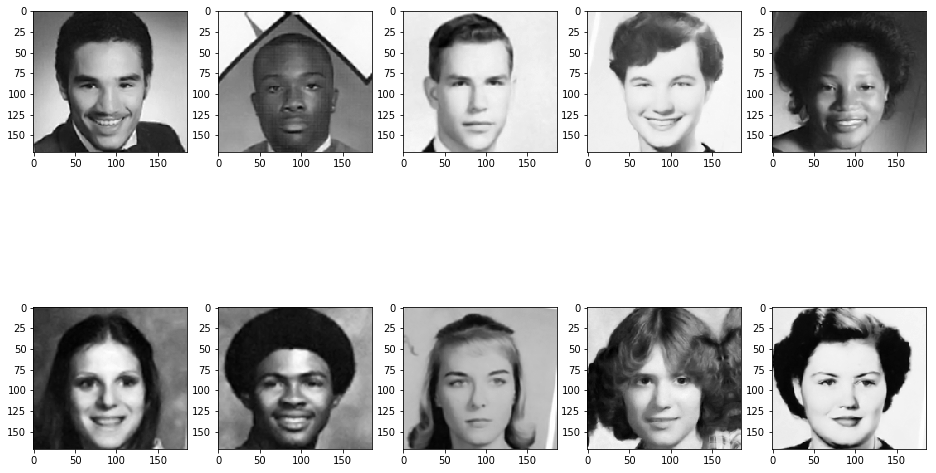

True year:	 [1984. 2000. 1961. 1955. 1984. 1979. 1979. 1961. 1981. 1955.]
Predicted year:	 [2004. 1976. 1962. 1961. 1989. 1981. 1978. 1964. 1981. 1952.]


In [92]:
# to turn off running averages in batch norm
vgg.eval()
for batch_input,batch_labels in valDataloader:
    batch_input = batch_input.to(device)
    batch_labels = label_mapping_v[batch_labels].data.numpy().T
    out = vgg(batch_input).cpu().data.numpy().T
    visualizeBatch(batch_input.cpu().data.numpy())
    print("True year:\t", batch_labels)
    print("Predicted year:\t", scaledToYear(out))
    break

### Weights Visualization

In [109]:
weights = next(vgg.parameters()).cpu().data.numpy()

In [110]:
weights = np.squeeze(weights)
weights.shape

(64, 3, 3)

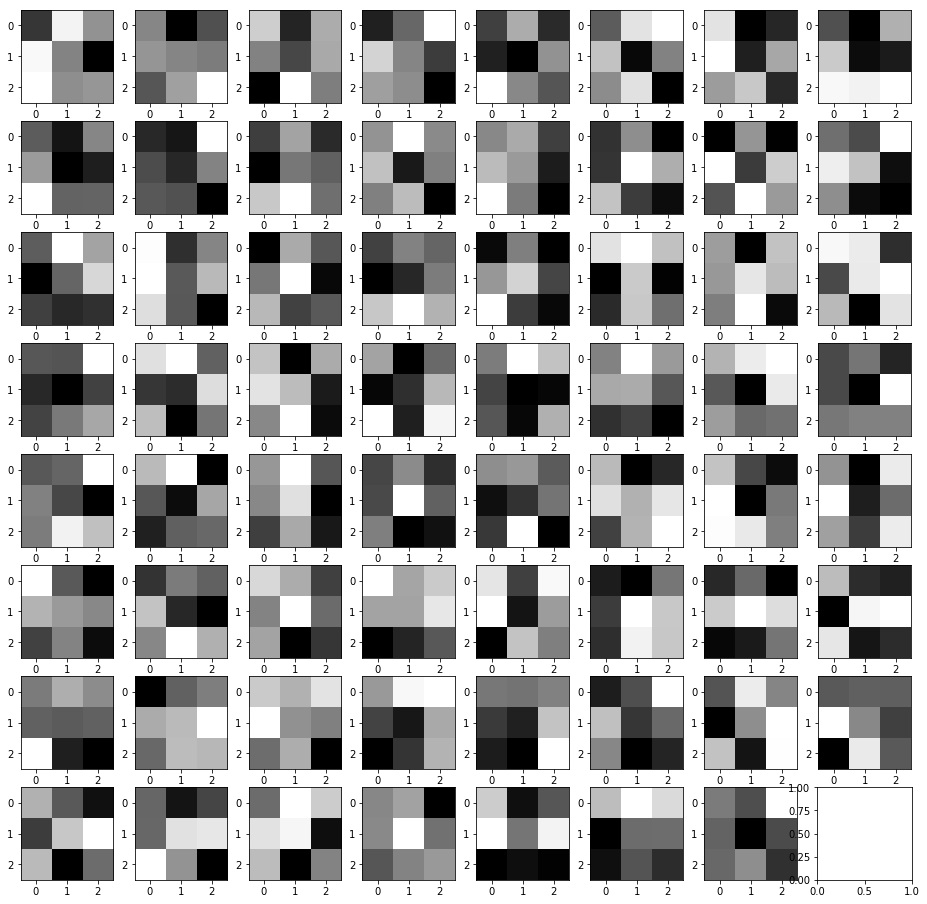

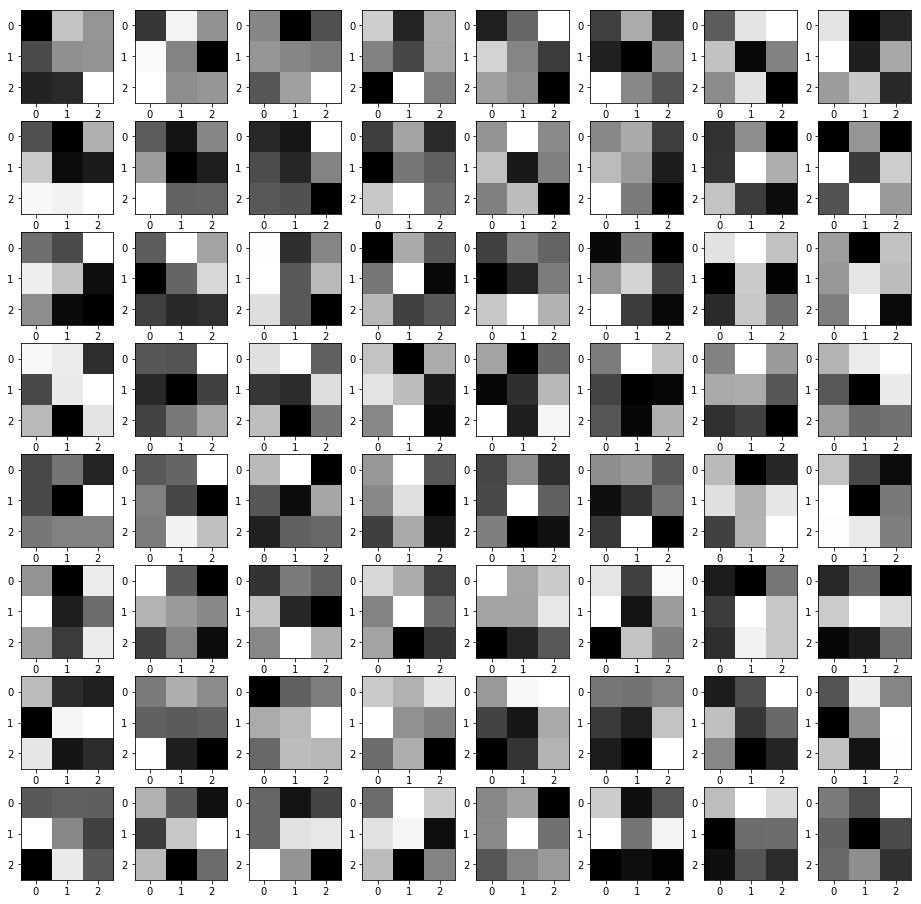

In [112]:
fig = plt.figure(figsize=(16, 16))
for i in range(1,65):
    plt.subplot(8,8,i)
    plt.imshow(weights[i-1,:,:],cmap='gray')
plt.show()